# Dummy Classifer

<span>Dummy classifiers are models that follow a heuristic for classification. Something like always "classify records as class 1", or "classify records at random from the target space." Not practical for use in production but useful when you start modeling for the first time to benchmark your initial models against this dummy classifier.</span>

### Import Preliminaries

In [24]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd 
import seaborn as sns
import warnings

from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting option
mpl.rcParams['figure.figsize'] = (9.0, 3.0)

# Set warning options
warnings.filterwarnings('ignore');

### Import Data

In [25]:
# Import Data
wine = load_wine()
X, y = wine.data, wine.target

# Train-test split the data
train_x, test_x, train_y, test_y = train_test_split(X,y)

wdf = pd.DataFrame(wine.data, columns=wine['feature_names'])
wdf = pd.concat([wdf, pd.DataFrame(wine.target, columns=['target'])], axis=1)
wdf.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.230,1.710,2.430,15.600,127.000,2.800,3.060,0.280,2.290,5.640,1.040,3.920,1065.000,0
1,13.200,1.780,2.140,11.200,100.000,2.650,2.760,0.260,1.280,4.380,1.050,3.400,1050.000,0
2,13.160,2.360,2.670,18.600,101.000,2.800,3.240,0.300,2.810,5.680,1.030,3.170,1185.000,0
3,14.370,1.950,2.500,16.800,113.000,3.850,3.490,0.240,2.180,7.800,0.860,3.450,1480.000,0
4,13.240,2.590,2.870,21.000,118.000,2.800,2.690,0.390,1.820,4.320,1.040,2.930,735.000,0


### Targets

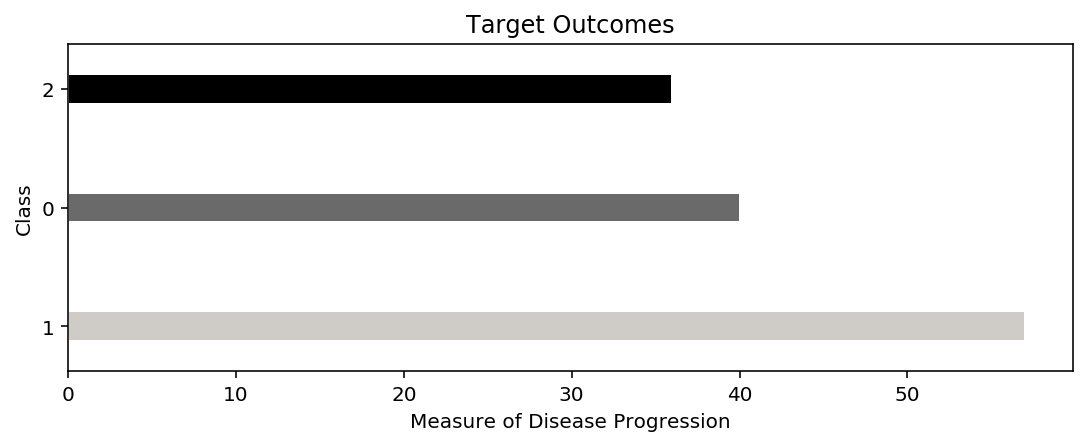

In [26]:
# Plot a barplot of the target clasees
pd.Series(train_y).value_counts().plot.barh(grid=False, color=['#CFCCC7','#6A6A6A','#000000'], width=0.25,edgecolor='w')
plt.title('Target Outcomes')
plt.ylabel('Class')
plt.xlabel('Measure of Disease Progression');

### Constant Dummy Model

In [27]:
# Fit the intial logistic model 
dm_model = DummyClassifier(constant=1)
dm_model.fit(train_x, train_y);
scores = cross_val_score(dm_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')

Cross Validation Score: 0.30522


### Startified Dummy Model

In [28]:
# Fit the intial logistic model 
dm_model = DummyClassifier(strategy='stratified')
dm_model.fit(train_x, train_y);
scores = cross_val_score(dm_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')

Cross Validation Score: 0.27125


### Random Dummy Model

In [34]:
# Fit the intial logistic model 
dm_model = DummyClassifier(strategy='uniform')
dm_model.fit(train_x, train_y);
scores = cross_val_score(dm_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')

Cross Validation Score: 0.34679


### Prior Dummy Model

In [35]:
# Fit the intial logistic model 
dm_model = DummyClassifier(strategy='prior')
dm_model.fit(train_x, train_y);
scores = cross_val_score(dm_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')

Cross Validation Score: 0.42830


### Logistic Regression

In [29]:
# Fit the intial logistic model 
lg_model = LogisticRegression(C=10000)
lg_model.fit(train_x, train_y);
scores = cross_val_score(lg_model, train_x, train_y, cv=10, scoring='accuracy')
print(f'Cross Validation Score: {scores.mean():.5f}')

Cross Validation Score: 0.94762


Author: Kavi Sekhon 